### Implementation Details

In [4]:
import torch
import math
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm, multivariate_normal, gaussian_kde
from tqdm import tqdm

from torch import nn

In [6]:
device = 'cuda' #if you don't have a cuda-supported GPU, use device='cpu' 
# device = 'cpu'
print(torch.__version__)

#### 1. VAE Base class, with ELBO and TVO loss function

In [24]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, dims, non_linearity):
        """
        Args:
            dims: list of ints
            non_linearity: differentiable function

        Returns: nn.Module which represents an MLP with architecture

            x -> Linear(dims[0], dims[1]) -> non_linearity ->
            ...
            Linear(dims[-3], dims[-2]) -> non_linearity ->
            Linear(dims[-2], dims[-1]) -> y
            last layer is linear layer"""

        super(MultilayerPerceptron, self).__init__()
        self.dims = dims
        self.non_linearity = non_linearity
        self.linear_modules = nn.ModuleList()
        for in_dim, out_dim in zip(dims[:-1], dims[1:]):
            self.linear_modules.append(nn.Linear(in_dim, out_dim))

    def forward(self, x):
        """
        Args:
            x: input data into this NN module, Tensor
        
        Returns: Feedforward Output
        """
        temp = x
        for linear_module in self.linear_modules[:-1]:
            temp = self.non_linearity(linear_module(temp))
        return self.linear_modules[-1](temp)
    
def init_mlp(in_dim, out_dim, hidden_dim, num_hid_layers=1, non_linearity=nn.ReLU()):
    """Initializes a MultilayerPerceptron.

    Args:
        in_dim: int, intput dimension
        out_dim: int, output dimension
        hidden_dim: int, hidden layer width
        num_hid_layers: int, hidden layer number
        non_linearity: differentiable function

    Returns: a MultilayerPerceptron with the architecture

        x -> Linear(in_dim, hidden_dim) -> non_linearity ->
        ...
        Linear(hidden_dim, hidden_dim) -> non_linearity ->
        Linear(hidden_dim, out_dim) -> y

        where num_layers = 0 corresponds to

        x -> Linear(in_dim, out_dim) -> y"""
    dims = [in_dim] + [hidden_dim for _ in range(num_hid_layers)] + [out_dim]
    return MultilayerPerceptron(dims, non_linearity)

def lognormexp(values, dim=0):
    """Exponentiates, normalizes and takes log of a tensor.

    Args:
        values: tensor [dim_1, ..., dim_N]
        dim: n

    Returns:
        result: tensor [dim_1, ..., dim_N]
            where result[i_1, ..., i_N] =
                                 exp(values[i_1, ..., i_N])
            log( ------------------------------------------------------------ )
                    sum_{j = 1}^{dim_n} exp(values[i_1, ..., j, ..., i_N])
    """

    log_denominator = torch.logsumexp(values, dim=dim, keepdim=True)
    # log_numerator = values
    return values - log_denominator

def exponentiate_and_normalize(values, dim=0):
    """Exponentiates and normalizes a tensor.

    Args:
        values: tensor [dim_1, ..., dim_N]
        dim: n

    Returns:
        result: tensor [dim_1, ..., dim_N]
            where result[i_1, ..., i_N] =
                            exp(values[i_1, ..., i_N])
            ------------------------------------------------------------
             sum_{j = 1}^{dim_n} exp(values[i_1, ..., j, ..., i_N])
    """

    return torch.exp(lognormexp(values, dim=dim))

def get_thermo_loss_from_log_weight_log_p_log_q(log_weight, log_p, log_q, partition, num_particles=1,
                                                integration='left'):
    """Args:
        log_weight: tensor of shape [batch_size, num_particles]
        log_p: tensor of shape [batch_size, num_particles]
        log_q: tensor of shape [batch_size, num_particles]
        partition: partition of [0, 1];
            tensor of shape [num_partitions + 1] where partition[0] is zero and
            partition[-1] is one;
            see https://en.wikipedia.org/wiki/Partition_of_an_interval
        num_particles: int
        integration: left, right or trapz

    Returns:
        loss: scalar that we call .backward() on and step the optimizer.
        elbo: average elbo over data
    """
    heated_log_weight = log_weight.unsqueeze(-1) * partition
    heated_normalized_weight = exponentiate_and_normalize(
        heated_log_weight, dim=1)
    thermo_logp = partition * log_p.unsqueeze(-1) + \
        (1 - partition) * log_q.unsqueeze(-1)

    wf = heated_normalized_weight * log_weight.unsqueeze(-1)
    w_detached = heated_normalized_weight.detach()
    wf_detached = wf.detach()
    if num_particles == 1:
        correction = 1
    else:
        correction = num_particles / (num_particles - 1)

    cov = correction * torch.sum(
        w_detached * (log_weight.unsqueeze(-1) - torch.sum(wf, dim=1, keepdim=True)).detach() *
        (thermo_logp - torch.sum(thermo_logp * w_detached, dim=1, keepdim=True)),
        dim=1)

    multiplier = torch.zeros_like(partition)
    if integration == 'trapz':
        multiplier[0] = 0.5 * (partition[1] - partition[0])
        multiplier[1:-1] = 0.5 * (partition[2:] - partition[0:-2])
        multiplier[-1] = 0.5 * (partition[-1] - partition[-2])
    elif integration == 'left':
        multiplier[:-1] = partition[1:] - partition[:-1]
    elif integration == 'right':
        multiplier[1:] = partition[1:] - partition[:-1]

    loss = -torch.mean(torch.sum(
        multiplier * (cov + torch.sum(
            w_detached * log_weight.unsqueeze(-1), dim=1)),
        dim=1))

    return loss


class VAE:
    def __init__(self, x_dim, z_dim, x_var, 
                encoder_hid_layer_num, encoder_hid_width,
                decoder_hid_layer_num, decoder_hid_width,
                encoder_nonlinearity = nn.ReLU(),
                decoder_nonlinearity = nn.ReLU(),
                device = 'cpu'):
        """VAE framework constructor
        Args:
            x_dim: Dimension of observations, int
            z_dim: Dimension of latent space, int
            x_var: varaince of generative model
            en/decoder_hid_layer_num: hidden layer number of en/decoder net, int
            en/decoder_hid_width: dim of en/decoder hidden layer, int
            en/decoder_nonlinearity: torch differentiable function"""
        self.x_dim = x_dim
        self.z_dim = z_dim
        self.x_var = x_var

        self.encoder = init_mlp(self.x_dim, self.z_dim*2, 
                                encoder_hid_width, encoder_hid_layer_num,
                                encoder_nonlinearity)
        self.decoder = init_mlp(self.z_dim, self.x_dim,
                                decoder_hid_width, decoder_hid_layer_num,
                                decoder_nonlinearity)
        if device == 'cuda': 
            self.encoder=self.encoder.cuda()
            self.decoder=self.decoder.cuda()
        self.objective_trace = []
        self.llkhd_KL_trace = []
    
    def generate(self, N=300, z_samples=None):
        """On CPU, use the generative model to generate x given zs sampled from the prior
        Returns: Synthetic observation points Pytorch Tensor with shape (N, x_dim)"""
        if z_samples is None: z_samples = torch.normal(0, 1, size=(N,self.z_dim))
        decodercpu = self.decoder.cpu()
        return decodercpu.forward(z_samples)
    
    def infer(self, x):
        """Use the encoder to infer mean and sigma of q(z|x)
        Args:
            x: observation points, torch tensor, shape (N, x_dim)
        Returns: 
            mean: mean of q(z|x), torch tensor, shape (N, z_dim)
            std: std of q(z|x), positive, torch tensor, shape (N, z_dim)"""
        z_params = self.encoder.forward(x)
        mean = z_params[:,:self.z_dim]
        parameterized_std = z_params[:,self.z_dim:]
        std = torch.exp(parameterized_std) # To keep the std positive
        return mean, std

    def llkhd_KL(self, x_train, S, device = 'cpu'):
        '''Output Log Likelihood and KL divergence, fro trace plot'''
        assert len(x_train.shape) == 2
        assert x_train.shape[1] == self.x_dim
        if S is not None:
            self.S = S
        N = x_train.shape[0] #sample numbers
        
        #infer zs with encoder 
        mean, std = self.infer(x_train)
        assert std.shape == (N, self.z_dim)
        assert mean.shape == (N, self.z_dim)
        
        #sample zs with the parameters
        if device == 'cuda': z_samples = torch.normal(0,1,size=(self.S, N, self.z_dim)).cuda() * std + mean
        if device == 'cpu': z_samples = torch.normal(0,1,size=(self.S, N, self.z_dim)) * std + mean
        assert z_samples.shape == (self.S, N, self.z_dim)
        
        #predict xs
        x = self.decoder.forward(z_samples)
        assert x.shape == (self.S, N, self.x_dim)
        
        #evaluate log_likelihood p(y_n)
        norm1 = torch.distributions.Normal(x, self.x_var**0.5)
        log_likelihood = torch.sum(norm1.log_prob(x_train), axis=-1)
        assert log_likelihood.shape == (self.S, N)
        
        #evaluate sampled zs under prior 
        norm2 = torch.distributions.Normal(0.0, 1.0)
        log_pz = torch.sum(norm2.log_prob(z_samples), axis=-1)
        assert log_pz.shape == (self.S, N)
        
        #evaluate sampled z's under variational distribution
        norm3 = torch.distributions.Normal(mean, std)
        log_qz_given_x = torch.sum(norm3.log_prob(z_samples), axis=-1)

        return [torch.mean(log_likelihood).item(), torch.mean(log_qz_given_x - log_pz).item()]

    
    def make_elbo_objective(self, x_train, S, device = 'cpu'):
        '''Make ELBO objective function'''
        assert len(x_train.shape) == 2
        assert x_train.shape[1] == self.x_dim
        if S is not None:
            self.S = S
        N = x_train.shape[0] #sample numbers
        
        #infer zs with encoder 
        mean, std = self.infer(x_train)
        assert std.shape == (N, self.z_dim)
        assert mean.shape == (N, self.z_dim)
        
        #sample zs with the parameters
        if device == 'cuda': z_samples = torch.normal(0,1,size=(self.S, N, self.z_dim)).cuda() * std + mean
        if device == 'cpu': z_samples = torch.normal(0,1,size=(self.S, N, self.z_dim)) * std + mean
        assert z_samples.shape == (self.S, N, self.z_dim)
        
        #predict xs
        x = self.decoder.forward(z_samples)
        assert x.shape == (self.S, N, self.x_dim)
        
        #evaluate log_likelihood p(y_n)
        norm1 = torch.distributions.Normal(x, self.x_var**0.5)
        log_likelihood = torch.sum(norm1.log_prob(x_train), axis=-1)
        assert log_likelihood.shape == (self.S, N)
        
        #evaluate sampled zs under prior 
        norm2 = torch.distributions.Normal(0.0, 1.0)
        log_pz = torch.sum(norm2.log_prob(z_samples), axis=-1)
        assert log_pz.shape == (self.S, N)
        
        #evaluate sampled z's under variational distribution
        norm3 = torch.distributions.Normal(mean, std)
        log_qz_given_x = torch.sum(norm3.log_prob(z_samples), axis=-1)
        
        elbo = torch.mean(log_likelihood - log_qz_given_x + log_pz)
        
        return -elbo
    
    def make_tvo_objective(self, x_train, S, partition, num_particles=10, integration='left', device='cpu'):
        '''Make TVO objective function'''
        assert len(x_train.shape) == 2
        assert x_train.shape[1] == self.x_dim
        if S is not None:
            self.S = S
        N = x_train.shape[0] #sample numbers
        
        #infer zs with encoder 
        mean, std = self.infer(x_train)
        assert std.shape == (N, self.z_dim)
        assert mean.shape == (N, self.z_dim)
        
        #sample zs with the parameters
        if device == 'cuda': z_samples = torch.normal(0,1,size=(self.S, N, self.z_dim)).cuda() * std + mean
        if device == 'cpu': z_samples = torch.normal(0,1,size=(self.S, N, self.z_dim)) * std + mean
        assert z_samples.shape == (self.S, N, self.z_dim)
        
        #predict xs
        x = self.decoder.forward(z_samples)
        assert x.shape == (self.S, N, self.x_dim)
        
        #evaluate log_likelihood log p_w(y_n)
        norm1 = torch.distributions.Normal(x, self.x_var**0.5)
        log_likelihood = torch.sum(norm1.log_prob(x_train), axis=-1)
        assert log_likelihood.shape == (self.S, N)
        
        #evaluate sampled zs under prior log q_v(z_n)
        norm2 = torch.distributions.Normal(0.0, 1.0)
        log_pz = torch.sum(norm2.log_prob(z_samples), axis=-1)
        assert log_pz.shape == (self.S, N)
        
        #evaluate sampled z's under variational distribution, p_w( zn | yn )
        norm3 = torch.distributions.Normal(mean, std)
        log_qz_given_x = torch.sum(norm3.log_prob(z_samples), axis=-1)
        
        log_weight = log_likelihood - log_qz_given_x + log_pz
        log_p = log_likelihood
        log_q = log_qz_given_x - log_pz
        
        return get_thermo_loss_from_log_weight_log_p_log_q(log_weight, 
                                                           log_p, 
                                                           log_q, 
                                                           partition, 
                                                           num_particles,
                                                           integration)

#### 2. Helper functions for training VAE, with and without LIN Trick

In [8]:
def calc_mi(vae, x_validation, device='cpu', S=1):
    '''Approximate the mutual information between x and z
    I(x, z) = E_xE_{q(z|x)}log(q(z|x)) - E_xE_{q(z|x)}log(q(z))
    Modified from the implementation by Author of the paper "LAGGING INFERENCE NETWORKS 
    AND POSTERIOR COLLAPSE IN VARIATIONAL AUTOENCODERS"
    see https://github.com/jxhe/vae-lagging-encoder/blob/master/modules/encoders/encoder.py
    
    This function will calculate the mutual information during the training with LIN trick,
    as a criterion wehther we should stop the agressive training. 
    
    Parameters:
    -----------
    vae: A vae instance, with .infer() method
    
    x_validation: Validation X data set
    
    Returns: Float
    '''
    N_batch = x_validation.shape[0]
    
    #infer zs with encoder 
    # 2D Tensor, shape [N_batch, z_dim]
    mean, std = vae.infer(x_validation)
    assert std.shape == (N_batch, vae.z_dim)
    assert mean.shape == (N_batch, vae.z_dim)
    
    ## Term 1: calculate Negative Entropy, E_{q(z|x)}log(q(z|x))
    # E_{q(z|x)}log(q(z|x)) = -0.5* z_dim *log(2*\pi) - 0.5*(1+log(std**2)).sum(-1)
    # 1D Tensor, shape [N_batch]
    neg_entropy = (-0.5 * vae.z_dim * math.log(2. * math.pi)- 0.5 * (1 + torch.log(std**2)).sum(-1))
    
    
    ## Term 2: calculate E_{q(z|x)}log(q(z))
    #sample zs with the parameters
    if device == 'cuda': z_samples = torch.normal(0,1,size=(S, N_batch, vae.z_dim)).cuda() * std + mean
    if device == 'cpu': z_samples = torch.normal(0,1,size=(S, N_batch, vae.z_dim)) * std + mean
    assert z_samples.shape == (S, N_batch, vae.z_dim)
    
    #evaluate sampled z's under variational distribution
    # 2D Tensor, shape [S, N_batch]
    norm1 = torch.distributions.Normal(mean, std)
    log_qz= torch.sum(norm1.log_prob(z_samples), axis=-1)
    
    return (torch.mean(neg_entropy) - torch.mean(log_qz)).item()

def train_ELBO_VAE_batched(x_train, 
                   x_var = 0.01,
                   z_dim = 1,
                   width = 50,
                   hidden_layers = 1, 
                   learning_rate = 0.01,
                   S = 10,
                   n_epochs = 5000, 
                   report_iter = 50, 
                   batch_size = 256,
                   device = 'cpu'):
    x_dim = x_train.shape[1]
    if device == 'cuda': x_trainT = torch.tensor(x_train).float().cuda()
    if device == 'cpu': x_trainT = torch.tensor(x_train).float()
    batch_num = int(x_train.shape[0]/batch_size)
    vae_instance = VAE(x_dim, z_dim, x_var, hidden_layers, width, hidden_layers, width)
    parameters = list(vae_instance.encoder.parameters())+list(vae_instance.decoder.parameters())
    optimizer = torch.optim.Adam(parameters, lr=learning_rate)
    counter=0
    for epoch in tqdm(range(n_epochs)):
        x_trainT=x_trainT[torch.randperm(x_trainT.size()[0])]
        for i in range(batch_num):
            x_batch = x_trainT[i*batch_size:(i+1)*batch_size,:]
            optimizer.zero_grad()
            loss = vae_instance.make_elbo_objective(x_trainT, S)
            loss.backward()
            optimizer.step()
            counter=counter+1
            if counter % report_iter == 0:
                vae_instance.objective_trace.append(loss.item())
                vae_instance.llkhd_KL_trace.append(vae_instance.llkhd_KL(x_batch, S, device=device))
    return vae_instance

def train_ELBO_LIN_VAE_batched(x_train,
                   x_val,
                   x_var = 0.01,
                   z_dim = 1,
                   width = 50,
                   hidden_layers = 1, 
                   learning_rate = 0.01,
                   S = 10,
                   n_epochs = 5000, 
                   report_iter = 50, 
                   batch_size = 256,
                   device = 'cpu'):
    x_dim = x_train.shape[1]
    if device == 'cuda': 
        x_trainT = torch.tensor(x_train).float().cuda()
        x_valT = torch.tensor(x_val).float().cuda()
    if device == 'cpu': 
        x_trainT = torch.tensor(x_train).float()
        x_valT = torch.tensor(x_val).float()
    batch_num = int(x_train.shape[0]/batch_size)
    vae_instance = VAE(x_dim, z_dim, x_var, hidden_layers, width, hidden_layers, width)
    enc_optimizer = torch.optim.Adam(vae_instance.encoder.parameters(), lr=learning_rate)
    dec_optimizer = torch.optim.Adam(vae_instance.decoder.parameters(), lr=learning_rate)
    counter = 0
    pre_mi = 0
    best_mi = 0
    mi_not_improved = 0
    aggressive_flag = True
    for epoch in tqdm(range(n_epochs)):
        x_trainT=x_trainT[torch.randperm(x_trainT.size()[0])]
        for i in range(batch_num):
            x_batch = x_trainT[i*batch_size:(i+1)*batch_size,:]
            sub_iter=0
            while aggressive_flag and sub_iter < 100:
                enc_optimizer.zero_grad()
                dec_optimizer.zero_grad()
                loss = vae_instance.make_elbo_objective(x_batch, S)
                loss.backward()
                enc_optimizer.step()
                sub_iter += 1
                
            enc_optimizer.zero_grad()
            dec_optimizer.zero_grad()
            loss = vae_instance.make_elbo_objective(x_batch, S)
            loss.backward()
            if not aggressive_flag:
                enc_optimizer.step()
            dec_optimizer.step()
            counter=counter+1
            if counter % report_iter == 0:
                vae_instance.objective_trace.append(loss.item())
                vae_instance.llkhd_KL_trace.append(vae_instance.llkhd_KL(x_batch, S, device=device))
            if aggressive_flag and counter % batch_num == 0:
                cur_mi = calc_mi(vae_instance, x_valT, device=device)
                if cur_mi - best_mi < 0:
                    mi_not_improved += 1
                    if mi_not_improved == 5:
                        print("At iteration {} aggresive_flag is set to False".format(counter))
                        aggressive_flag = False
                else:
                    best_mi = cur_mi
                pre_mi = cur_mi

    return vae_instance

def train_TVO_VAE_batched(x_train, 
                  x_var = 0.01,
                  z_dim = 1,
                  width = 50,
                  hidden_layers = 1, 
                  learning_rate = 0.01, 
                  partition = torch.tensor([0,0.25,0.5,0.75,1.]),
                  S = 10,
                  n_epochs = 5000, 
                  report_iter = 50, 
                  batch_size = 256,
                  device = 'cpu'):
    x_dim = x_train.shape[1]
    if device == 'cuda': 
        x_trainT = torch.tensor(x_train).float().cuda()
        partition = partition.cuda()
    if device == 'cpu': x_trainT = torch.tensor(x_train).float()
    batch_num = int(x_train.shape[0]/batch_size)
    vae_instance = VAE(x_dim, z_dim, x_var, hidden_layers, width, hidden_layers, width)
    parameters = list(vae_instance.encoder.parameters())+list(vae_instance.decoder.parameters())
    optimizer = torch.optim.Adam(parameters, lr=learning_rate)
    counter=0
    for epoch in tqdm(range(n_epochs)):
        x_trainT=x_trainT[torch.randperm(x_trainT.size()[0])]
        for i in range(batch_num):
            x_batch = x_trainT[i*batch_size:(i+1)*batch_size,:]
            optimizer.zero_grad()
            loss = vae_instance.make_tvo_objective(x_batch, S, partition)
            loss.backward()
            optimizer.step()
            counter=counter+1
            if counter % report_iter == 0:
                vae_instance.objective_trace.append(loss.item())
                vae_instance.llkhd_KL_trace.append(vae_instance.llkhd_KL(x_batch, S, device=device))
    return vae_instance

def train_TVO_LIN_VAE_batched(x_train,
                   x_val,
                   x_var = 0.01,
                   z_dim = 1,
                   width = 50,
                   hidden_layers = 1, 
                   learning_rate = 0.01,
                   partition = torch.tensor([0,0.25,0.5,0.75,1.]),
                   S = 10,
                   n_epochs = 5000, 
                   report_iter = 50, 
                   batch_size = 256,
                   device = 'cpu'):
    x_dim = x_train.shape[1]
    if device == 'cuda': 
        x_trainT = torch.tensor(x_train).float().cuda()
        x_valT = torch.tensor(x_val).float().cuda()
    if device == 'cpu': 
        x_trainT = torch.tensor(x_train).float()
        x_valT = torch.tensor(x_val).float()
    batch_num = int(x_train.shape[0]/batch_size)
    vae_instance = VAE(x_dim, z_dim, x_var, hidden_layers, width, hidden_layers, width)
    enc_optimizer = torch.optim.Adam(vae_instance.encoder.parameters(), lr=learning_rate)
    dec_optimizer = torch.optim.Adam(vae_instance.decoder.parameters(), lr=learning_rate)
    counter = 0
    pre_mi = 0
    best_mi = 0
    mi_not_improved = 0
    aggressive_flag = True
    for epoch in tqdm(range(n_epochs)):
        x_trainT=x_trainT[torch.randperm(x_trainT.size()[0])]
        for i in range(batch_num):
            x_batch = x_trainT[i*batch_size:(i+1)*batch_size,:]
            sub_iter=0
            while aggressive_flag and sub_iter < 100:
                enc_optimizer.zero_grad()
                dec_optimizer.zero_grad()
                loss = vae_instance.make_tvo_objective(x_batch, S, partition)
                loss.backward()
                enc_optimizer.step()
                sub_iter += 1
                
            enc_optimizer.zero_grad()
            dec_optimizer.zero_grad()
            loss = vae_instance.make_tvo_objective(x_batch, S, partition)
            loss.backward()
            if not aggressive_flag:
                enc_optimizer.step()
            dec_optimizer.step()
            counter=counter+1
            if counter % report_iter == 0:
                vae_instance.objective_trace.append(loss.item())
                vae_instance.llkhd_KL_trace.append(vae_instance.llkhd_KL(x_batch, S, device=device))
            if aggressive_flag and counter % batch_num == 0:
                cur_mi = calc_mi(vae_instance, x_valT, device=device)
                if cur_mi - best_mi < 0:
                    mi_not_improved += 1
                    if mi_not_improved == 5:
                        print("At iteration {} aggresive_flag is set to False".format(counter))
                        aggressive_flag = False
                else:
                    best_mi = cur_mi
                pre_mi = cur_mi

    return vae_instance

def random_start_ELBO_VAE(x_train, 
                  x_var = 0.01,
                  z_dim = 1,
                  width = 50,
                  hidden_layers = 1, 
                  learning_rate = 0.01,
                  S = 10,
                  n_epochs = 5000, 
                  report_iter = 50, 
                  batch_size = 256,
                  restart = 5):
    best_vae = train_ELBO_VAE_batched(x_train, 
                  x_var = x_var,
                  z_dim = z_dim,
                  width = width,
                  hidden_layers = hidden_layers, 
                  learning_rate = learning_rate,
                  S = S,
                  n_epochs = n_epochs, 
                  report_iter = report_iter, 
                  batch_size = batch_size)
    loss_min = best_vae.objective_trace[-1]
    for i in range(1, restart):
        cur_vae = train_ELBO_VAE_batched(x_train, 
                  x_var = x_var,
                  z_dim = z_dim,
                  width = width,
                  hidden_layers = hidden_layers, 
                  learning_rate = learning_rate, 
                  S = S,
                  n_epochs = n_epochs, 
                  report_iter = report_iter, 
                  batch_size = batch_size)
        cur_loss = cur_vae.objective_trace[-1]
        if cur_loss < loss_min:
            loss_min = cur_loss
            best_vae = cur_vae
    return best_vae

def random_start_TVO_VAE(x_train, 
                  x_var = 0.01,
                  z_dim = 1,
                  width = 50,
                  hidden_layers = 1, 
                  learning_rate = 0.01, 
                  partition = torch.tensor([0,0.25,0.5,0.75,1.]),
                  S = 10,
                  n_epochs = 5000, 
                  report_iter = 50, 
                  batch_size = 256,
                  restart = 5):
    best_vae = train_TVO_VAE_batched(x_train, 
                  x_var = x_var,
                  z_dim = z_dim,
                  width = width,
                  hidden_layers = hidden_layers, 
                  learning_rate = learning_rate, 
                  partition = partition,
                  S = S,
                  n_epochs = n_epochs, 
                  report_iter = report_iter, 
                  batch_size = batch_size)
    loss_min = best_vae.objective_trace[-1]
    for i in range(1, restart):
        cur_vae = train_TVO_VAE_batched(x_train, 
                  x_var = x_var,
                  z_dim = z_dim,
                  width = width,
                  hidden_layers = hidden_layers, 
                  learning_rate = learning_rate, 
                  partition = partition,
                  S = S,
                  n_epochs = n_epochs, 
                  report_iter = report_iter, 
                  batch_size = batch_size)
        cur_loss = cur_vae.objective_trace[-1]
        if cur_loss < loss_min:
            loss_min = cur_loss
            best_vae = cur_vae
    return best_vae


#### 3. Helper functions for visualization

In [69]:
def visualize_VAE(vae_instance,
                  x_train, 
                  mode,
                  x_var=0.01,
                  number_samples=300,
                  figsize=(10,10)):
    x_hat = vae_instance.generate(number_samples).detach().cpu()
    x_hat = x_hat + np.random.normal(0, x_var**0.5, size=x_hat.shape)
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.scatter(x_train[:,0], x_train[:,1], color='black',s=20, label="Training Data")
    ax.scatter(x_hat[:, 0], x_hat[:,1], color='blue', s=20, alpha=0.5, label="Generative Data")
    ax.set_title('VAE Generative data with {}'.format(mode), fontsize=20)
    plt.show()

def visualize_pdf(data, lim=1, c_map="magma_r"):
    kde = gaussian_kde(data.T)

    # evaluate on a regular grid
    xgrid = np.linspace(-lim, lim, 60)
    ygrid = np.linspace(-lim, lim, 60)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))

    plt.figure(figsize=(5,4))
    plt.imshow(Z.reshape(Xgrid.shape),
               origin='lower', aspect='auto',
               extent=[-lim, lim, -lim, lim],
               cmap=c_map)
    plt.xlabel('x1')
    plt.ylabel('x2')
    cb = plt.colorbar()
    cb.set_label("density")

def compare_VAE(elbo_vae, tvo_vae, x_train, number_samples=2000, x_var=0.02, lim=2, c_map="magma_r"):

    kde = gaussian_kde(x_train.T)
    
    x_hat_elbo = elbo_vae.generate(number_samples).detach().cpu()
    x_hat_elbo = x_hat_elbo + np.random.normal(0, x_var**0.5, size=x_hat_elbo.shape)
    kde_elbo = gaussian_kde(x_hat_elbo.T)
    
    x_hat_tvo = tvo_vae.generate(number_samples).detach().cpu()
    x_hat_tvo = x_hat_tvo + np.random.normal(0, x_var**0.5, size=x_hat_tvo.shape)
    kde_tvo = gaussian_kde(x_hat_tvo.T)
    
    # evaluate on a regular grid
    xgrid = np.linspace(-lim, lim, 60)
    ygrid = np.linspace(-lim, lim, 60)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))
    Z_elbo = kde_elbo(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))
    Z_tvo = kde_tvo(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    im=ax[0].imshow(Z.reshape(Xgrid.shape),
               origin='lower', aspect='auto',
               extent=[-lim, lim, -lim, lim],
               cmap=c_map)
    ax[0].set_xlabel('x1')
    ax[0].set_ylabel('x2')
    ax[0].set_title('data')
    fig.colorbar(im, ax=ax[0])
    
    im=ax[1].imshow(Z_elbo.reshape(Xgrid.shape),
               origin='lower', aspect='auto',
               extent=[-lim, lim, -lim, lim],
               cmap=c_map)
    ax[1].set_xlabel('x1')
    ax[1].set_ylabel('x2')
    ax[1].set_title('elbo')
    fig.colorbar(im, ax=ax[1])
    
    im=ax[2].imshow(Z_tvo.reshape(Xgrid.shape),
               origin='lower', aspect='auto',
               extent=[-lim, lim, -lim, lim],
               cmap=c_map)
    ax[2].set_xlabel('x1')
    ax[2].set_ylabel('x2')
    ax[2].set_title('tvo')
    fig.colorbar(im, ax=ax[2])
    plt.show()


def compare_VAE_true_function(elbo_vae, tvo_vae, z_dim, number_samples, z_samples, z_samples_np, task='crosscurve'):
    z_samples=z_samples.reshape(-1,z_dim)
    x_elbo=elbo_vae.generate(z_samples=z_samples).detach().cpu()
    x_tvo=tvo_vae.generate(z_samples=z_samples).detach().cpu()
    if task == 'crosscurve': x_true=synthesize_crosscurve(number_samples, z_list=z_samples_np, noise_var=0)
    if task == 'threeclusters': x_true=synthesize_threeclusters(number_samples, z_list=z_samples_np, noise_var=0)
    fig=plt.figure()
    ax=fig.gca(projection='3d')
    ax.plot(x_true[:,0].flatten(), x_true[:,1].flatten(), z_samples_np.flatten(), color = 'black', label='true f_theta(z)')
    ax.plot(x_elbo[:,0].flatten(), x_elbo[:,1].flatten(), z_samples.flatten(), color = 'blue', label='learned f_theta(z)-elbo')
    ax.plot(x_tvo[:,0].flatten(), x_tvo[:,1].flatten(), z_samples.flatten(), color = 'red', label='learned f_theta(z)-tvo')
    ax.legend()
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('z')
    plt.show()

def compare_VAE_line(elbo_vae, tvo_vae, z_dim, number_samples, 
                     z_samples, z_samples_np, x_train, x_var=0.02, lim=2, c_map1="magma_r", c_map2="cool",
                     task="crosscurve"):
    # data for curve
    z_samples=z_samples.reshape(-1,z_dim)
    x_elbo=elbo_vae.generate(z_samples=z_samples).detach().cpu()
    x_tvo=tvo_vae.generate(z_samples=z_samples).detach().cpu()    
    if task == 'crosscurve': x_true=synthesize_crosscurve(number_samples, z_list=z_samples_np, noise_var=0)
    if task == 'threeclusters': x_true=synthesize_threeclusters(number_samples, z_list=z_samples_np, noise_var=0)

    kde = gaussian_kde(x_train.T)
    
    x_hat_elbo = x_elbo + np.random.normal(0, x_var**0.5, size=x_elbo.shape)
    kde_elbo = gaussian_kde(x_hat_elbo.T)
    
    x_hat_tvo = x_tvo + np.random.normal(0, x_var**0.5, size=x_tvo.shape)
    kde_tvo = gaussian_kde(x_hat_tvo.T)
    
    # evaluate on a regular grid
    xgrid = np.linspace(-lim, lim, 60)
    ygrid = np.linspace(-lim, lim, 60)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))
    Z_elbo = kde_elbo(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))
    Z_tvo = kde_tvo(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    im=ax[0].imshow(Z.reshape(Xgrid.shape),
               origin='lower', aspect='auto',
               extent=[-lim, lim, -lim, lim],
               cmap=c_map1)
    scatter0 = ax[0].scatter(x_true[:,0], x_true[:,1], s=2, c=z_samples_np.flatten(),cmap=c_map2)
    ax[0].set_xlabel('x1')
    ax[0].set_ylabel('x2')
    ax[0].set_title('data')

    im=ax[1].imshow(Z_elbo.reshape(Xgrid.shape),
               origin='lower', aspect='auto',
               extent=[-lim, lim, -lim, lim],
               cmap=c_map1)
    scatter1 = ax[1].scatter(x_elbo[:,0], x_elbo[:,1], s=2, c=z_samples.numpy().flatten(),cmap=c_map2)
    ax[1].set_xlabel('x1')
    ax[1].set_ylabel('x2')
    ax[1].set_title('elbo')
    
    im=ax[2].imshow(Z_tvo.reshape(Xgrid.shape),
               origin='lower', aspect='auto',
               extent=[-lim, lim, -lim, lim],
               cmap=c_map1)
    scatter2 = ax[2].scatter(x_tvo[:,0], x_tvo[:,1], s=2, c=z_samples.numpy().flatten(),cmap=c_map2)
    ax[2].set_xlabel('x1')
    ax[2].set_ylabel('x2')
    ax[2].set_title('tvo')

    # add axes for colorbar
    cbaxes_im = fig.add_axes([0.2, -0.1, 0.3, 0.3]) 
    cbaxes_scatter = fig.add_axes([0.55, -0.1, 0.3, 0.3]) 

    c_im = plt.colorbar(im, ax=cbaxes_im, orientation="horizontal")
    c_scatter = plt.colorbar(scatter2, orientation="horizontal")
    c_im.set_label('p(x)')
    c_scatter.set_label('z')
    
    # erase axes
    cbaxes_im.set_axis_off()
    cbaxes_scatter.set_axis_off()

    plt.show()

def aggregated_posterior(elbo_vae, tvo_vae, x_train, number_sample_per):
    
    x_train_torch = torch.from_numpy(x_train).float()
    
    mean_z_elbo, std_z_elbo = elbo_vae.infer(x_train_torch)
    mean_z_tvo, std_z_tvo = tvo_vae.infer(x_train_torch)

    mean_z_elbo = mean_z_elbo.detach().cpu().numpy()
    std_z_elbo = std_z_elbo.detach().cpu().numpy()

    mean_z_tvo = mean_z_tvo.detach().cpu().numpy()
    std_z_tvo = std_z_tvo.detach().cpu().numpy()

    z_sample_elbo = []
    z_sample_tvo = []

    for i in range(x_train.shape[0]):
        z_sample_tvo.append(np.random.normal(mean_z_tvo[i], np.exp(std_z_tvo[i]), number_sample_per))
        z_sample_elbo.append(np.random.normal(mean_z_elbo[i], np.exp(std_z_elbo[i]), number_sample_per))
    normal_ground_truth = np.random.normal(0,1,number_sample_per * x_train.shape[0])

    kde_elbo = gaussian_kde(np.array(z_sample_elbo).flatten())
    kde_tvo = gaussian_kde(np.array(z_sample_tvo).flatten())
    kde_normal = gaussian_kde(np.random.normal(0,1, 2000*50))
    
    xs = np.linspace(-5,5,1000)
    
    plt.plot(xs,kde_normal(xs), color="red", label="p(z)")    
    plt.plot(xs,kde_elbo(xs), color="blue", label="q_\phi(z)-ELBO")
    plt.plot(xs,kde_tvo(xs), color="black", label="q_\phi(z)-TVO")
    
    plt.legend()
    plt.xlabel('z')
    
    plt.show()

def true_posterior(x_value, x_var, f_true, z_list=np.linspace(-3,3,500)):
    '''
    This function outputs Posterior p(z|x) under True f_{theta}(z) 
    evaluated at the z_list points

    Parameters
    ----------
    x_value: numpy array or list, shape [2,]
        The x point which conditioned on. For example, x_val=[0.2,0.2]

    x_var: float
        variance of the gaussian distribution in x space

    f_true: function, should have one argument, output a shape (2,) array/list
        The true funtion that transfer z to x_mean = f(z)

    z_list: a list of z points you want to evaluate the posterior

    Returns
    -------
    p(z|x), a list of values, same length as z_list

    '''
    posterior_list=[]
    assert np.array(x_value).shape == (2,)

    for z in z_list:
        x_mean = f_true(z)
        p_x_z = multivariate_normal.pdf(x_value, mean=x_mean, cov=x_var)
        p_z = norm.pdf(z, loc=0., scale=1.)
        p_z_x_unnormalized = p_x_z * p_z 

        posterior_list.append(p_z_x_unnormalized)

    posterior_list = np.array(posterior_list)

    # You can use an MC estimates instead for the normalizer, i am lazy here
    bin_size = (z_list[-1] - z_list[0])/len(z_list)
    normalizer = np.sum(posterior_list)*bin_size

    return posterior_list/normalizer

def trained_posterior(x_value, x_var, vae_instance, z_list=np.linspace(-3,3,500)):
    '''
    This function outputs Posterior p(z|x) under True f_{theta}(z) 
    evaluated at the z_list points
    Parameters
    ----------
    x_value: numpy array or list, shape [2,]
        The x point which conditioned on. For example, x_val=[0.2,0.2]
    x_var: float
        variance of the gaussian distribution in x space
    f_true: function, should have one argument, output a shape (2,) array/list
        The true funtion that transfer z to x_mean = f(z)
    z_list: a list of z points you want to evaluate the posterior
    Returns
    -------
    p(z|x), a list of values, same length as z_list
    '''
    posterior_list=[]
    assert np.array(x_value).shape == (2,)
    x_mean_list = vae_instance.decoder.cpu().forward(torch.tensor(z_list.reshape(-1,1)).float()).detach().numpy()
    for x_mean, z in zip(x_mean_list, z_list):
        p_x_z = multivariate_normal.pdf(x_value, mean=x_mean, cov=x_var)
        p_z = norm.pdf(z, loc=0., scale=1.)
        p_z_x_unnormalized = p_x_z * p_z 

        posterior_list.append(p_z_x_unnormalized)

    posterior_list = np.array(posterior_list)

    # You can use an MC estimates instead for the normalizer, i am lazy here
    bin_size = (z_list[-1] - z_list[0])/len(z_list)
    normalizer = np.sum(posterior_list)*bin_size

    return posterior_list/normalizer


#### 4. Helper functions to generate synthetic data

In [10]:
def synthesize_crosscurve(sample_nums=2000, z_list=None, noise_var=0.02):
    u = lambda z: np.pi*(0.6+1.8*norm.cdf(z))
    f1 = lambda u: (1./np.sqrt(2))*(np.cos(u)/((np.sin(u))**2 + 1.))
    f2 = lambda u: (np.sqrt(2)) * (np.cos(u) * np.sin(u))/((np.sin(u))**2 + 1.)

    if z_list is None: z_list = np.random.normal(0,1,sample_nums)
    assert len(z_list) == sample_nums, "number of z_list should equal to sample_nums"

    u_list = u(z_list)
    f1_list = f1(u_list) + np.random.normal(0, np.sqrt(noise_var), sample_nums)
    f2_list = f2(u_list) + np.random.normal(0, np.sqrt(noise_var), sample_nums)
    return np.vstack([f1_list, f2_list]).T


def synthesize_threeclusters(sample_nums=2000, z_list=None, noise_var=0.2):
    u = lambda z: (2*np.pi)/(1.+np.exp(-0.5*np.pi*z))
    t = lambda u: 2*np.tanh(10*u - 20*np.floor(u/2.) -10.) + 4.*np.floor(u/2.) + 2
    f1 = lambda t: np.cos(t)
    f2 = lambda t: np.sin(t)

    if z_list is None: z_list = np.random.normal(0,1,sample_nums)
    assert len(z_list) == sample_nums, "number of z_list should equal to sample_nums"

    u_list = u(z_list)
    t_list = t(u_list)
    f1_list = f1(t_list) + np.random.normal(0, np.sqrt(noise_var), sample_nums)
    f2_list = f2(t_list) + np.random.normal(0, np.sqrt(noise_var), sample_nums)
    return np.vstack([f1_list, f2_list]).T

### Experimentation and Visualization:
...

#### Cross curve data

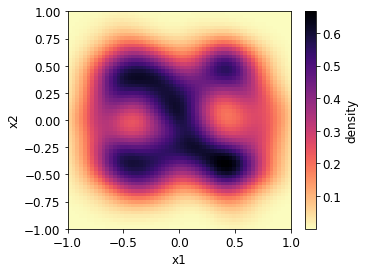

In [12]:
# Prepare data
z_train = np.random.normal(0,1,2000)
x_train = synthesize_crosscurve(sample_nums=2000, z_list=z_train)

z_val = np.random.normal(0,1,1000)
x_val = synthesize_crosscurve(sample_nums=1000, z_list=z_val)

# Visualize training data pdf
visualize_pdf(x_train, lim=1, c_map= 'magma_r')

Train VAE with ELBO objective

In [25]:
# Train with ELBO
# Most arguments of the following functions have reasonable default settings, i list them all here for a pedagogical reason
elbo_vae_instance = train_ELBO_VAE_batched(x_train, 
                                                 x_var=0.02,
                                                 z_dim=1,
                                                 width=50,
                                                 hidden_layers=3,
                                                 learning_rate=0.001,
                                                 S=10,
                                                 n_epochs= 5000,
                                                 report_iter=10,
                                                 batch_size=500,
                                                 device=device)
# Or use random_start_ELBO_VAE() for several individual runs

100%|██████████| 100/100 [00:11<00:00,  8.91it/s]


Train VAE with TVO objective

In [26]:
# Train with TVO
tvo_vae_instance = train_TVO_VAE_batched(x_train,
                                                x_var=0.02,
                                                z_dim=1,
                                                width=50,
                                                hidden_layers=3,
                                                learning_rate=0.001,
                                                partition=torch.tensor([0.0,0.25,0.50,0.75,1.0]),
                                                S=10,
                                                n_epochs=5000,
                                                report_iter=10,
                                                batch_size=500,
                                                device=device)
# Or use random_start_TVO_VAE() for several individual runs

100%|██████████| 100/100 [00:06<00:00, 16.19it/s]


Train VAE with ELBO objective + LIN trick

In [27]:
# Train with ELBO + LIN
elbo_lin_vae_instance = train_ELBO_LIN_VAE_batched(x_train,
                                                 x_val,
                                                 x_var=0.02,
                                                 z_dim=1,
                                                 width=50,
                                                 hidden_layers=1,
                                                 learning_rate=0.01,
                                                 S=10,
                                                 n_epochs=5000,
                                                 report_iter=50,
                                                 batch_size=256,
                                                 device=device)

100%|██████████| 100/100 [00:21<00:00,  4.62it/s]


Train VAE with TVO objective + LIN trick

In [28]:
# Train with TVO + LIN
tvo_lin_vae_instance = train_TVO_LIN_VAE_batched(x_train,
                                                x_val,
                                                x_var=0.02,
                                                z_dim=1,
                                                width=50,
                                                hidden_layers=1,
                                                learning_rate=0.01,
                                                partition=torch.tensor([0.0,0.25,0.50,0.75,1.0]),
                                                S=10,
                                                n_epochs=5000,
                                                report_iter=50,
                                                batch_size=256,
                                                device=device)

100%|██████████| 100/100 [00:31<00:00,  3.16it/s]


Objective trace during training 

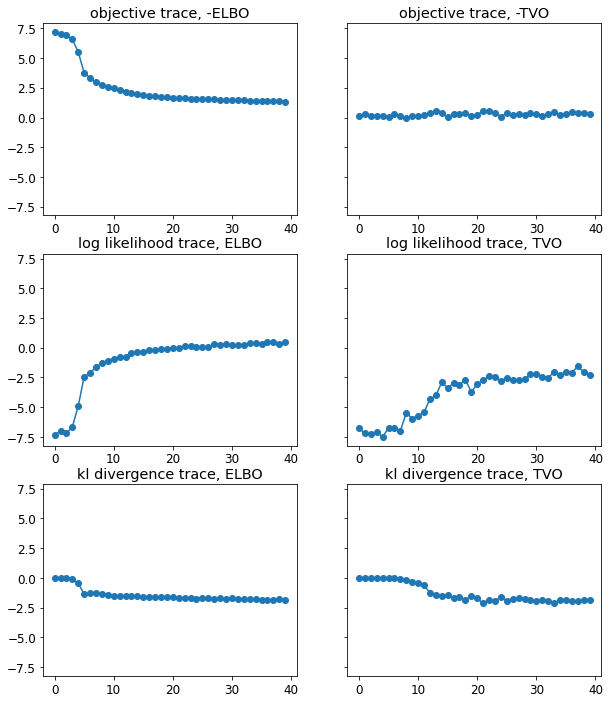

In [29]:
# Plot out the loss function, log likelihood, kl divergence trace
elbo_vae_instance_llkl = np.array(elbo_vae_instance.llkhd_KL_trace).reshape(-1,2)
tvo_vae_instance_llkl = np.array(tvo_vae_instance.llkhd_KL_trace).reshape(-1,2)
fig, ax=plt.subplots(3,2, figsize=(10,12), sharey=True)
ax[0][0].plot(elbo_vae_instance.objective_trace, 'o-')
ax[0][0].set_title('objective trace, -ELBO')
ax[0][1].plot(tvo_vae_instance.objective_trace, 'o-')
ax[0][1].set_title('objective trace, -TVO')
ax[1][0].plot(elbo_vae_instance_llkl[:,0], 'o-')
ax[1][0].set_title('log likelihood trace, ELBO')
ax[1][1].plot(tvo_vae_instance_llkl[:,0], 'o-')
ax[1][1].set_title('log likelihood trace, TVO')
ax[2][0].plot(-elbo_vae_instance_llkl[:,1], 'o-')
ax[2][0].set_title('kl divergence trace, ELBO')
ax[2][1].plot(-tvo_vae_instance_llkl[:,1], 'o-')
ax[2][1].set_title('kl divergence trace, TVO')
plt.show()

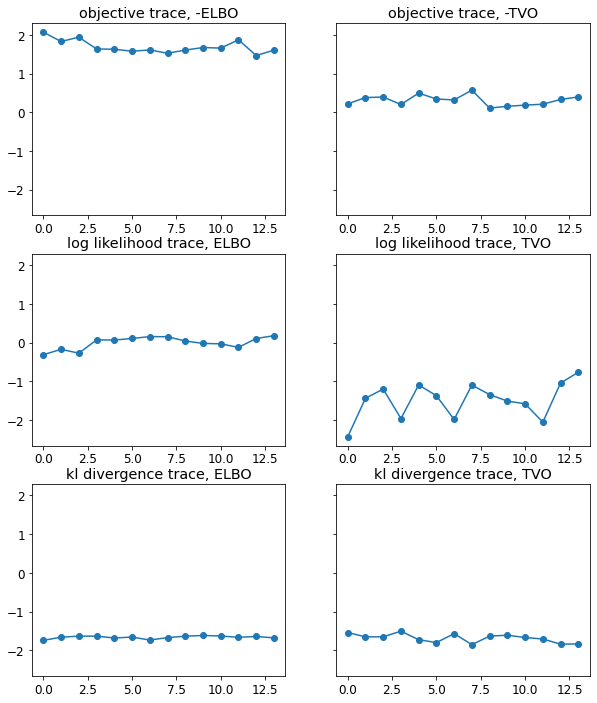

In [30]:
# Plot out the loss function, log likelihood, kl divergence trace
elbo_lin_vae_instance_llkl = np.array(elbo_lin_vae_instance.llkhd_KL_trace).reshape(-1,2)
tvo_lin_vae_instance_llkl = np.array(tvo_lin_vae_instance.llkhd_KL_trace).reshape(-1,2)
fig, ax=plt.subplots(3,2, figsize=(10,12), sharey=True)
ax[0][0].plot(elbo_lin_vae_instance.objective_trace, 'o-')
ax[0][0].set_title('objective trace, -ELBO')
ax[0][1].plot(tvo_lin_vae_instance.objective_trace, 'o-')
ax[0][1].set_title('objective trace, -TVO')
ax[1][0].plot(elbo_lin_vae_instance_llkl[:,0], 'o-')
ax[1][0].set_title('log likelihood trace, ELBO')
ax[1][1].plot(tvo_lin_vae_instance_llkl[:,0], 'o-')
ax[1][1].set_title('log likelihood trace, TVO')
ax[2][0].plot(-elbo_lin_vae_instance_llkl[:,1], 'o-')
ax[2][0].set_title('kl divergence trace, ELBO')
ax[2][1].plot(-tvo_lin_vae_instance_llkl[:,1], 'o-')
ax[2][1].set_title('kl divergence trace, TVO')
plt.show()

Compare PDF from decoder with the ground truth PDF

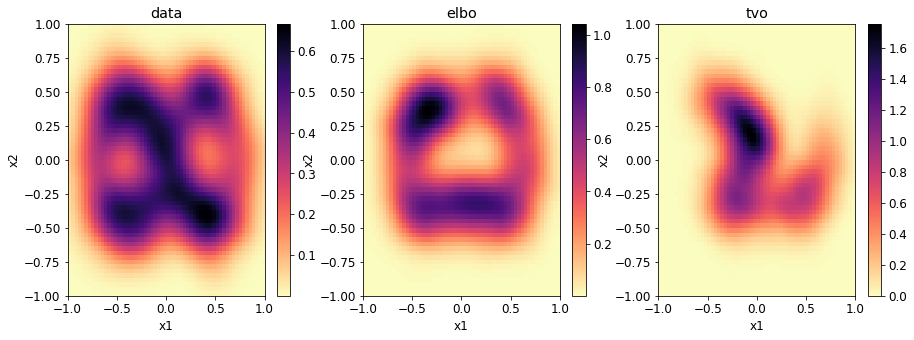

In [31]:
# Visualize PDF by a helper function
compare_VAE(elbo_vae_instance, tvo_vae_instance, x_train,
                 number_samples=10000, x_var=0.02,
                 lim=1,
                 c_map='magma_r')

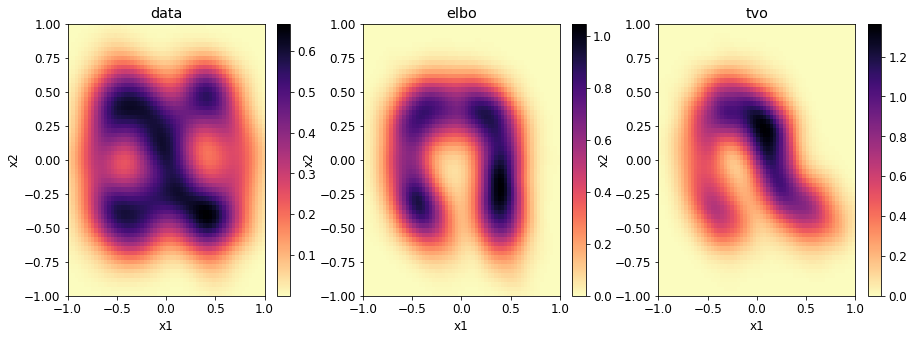

In [32]:
# Visualize PDF by a helper function
compare_VAE(elbo_lin_vae_instance, tvo_lin_vae_instance, x_train,
                 number_samples=10000, x_var=0.02,
                 lim=1,
                 c_map='magma_r')

True vs. learned pθ(x), and learned vs. true fθ(z), colored by the value of z.

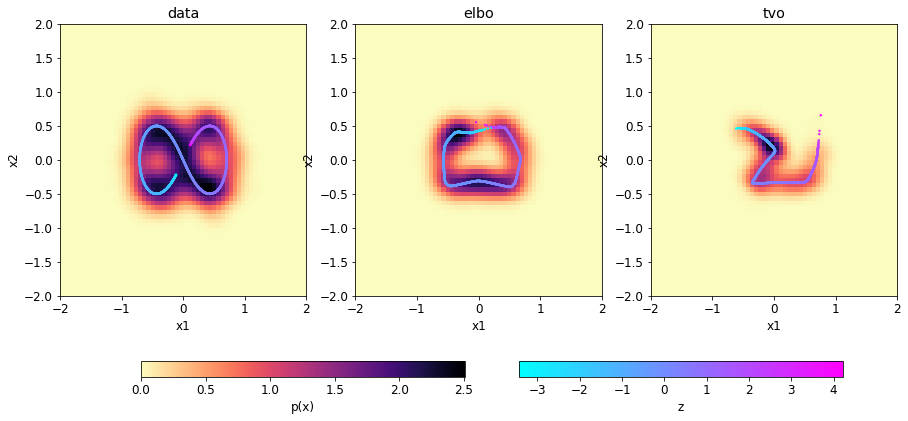

In [33]:
compare_VAE_line(elbo_vae_instance, tvo_vae_instance, 1, 2000, torch.normal(0, 1, size=(2000,1)),
                z_train, x_train, 0.02, 2, "magma_r", "cool","crosscurve")



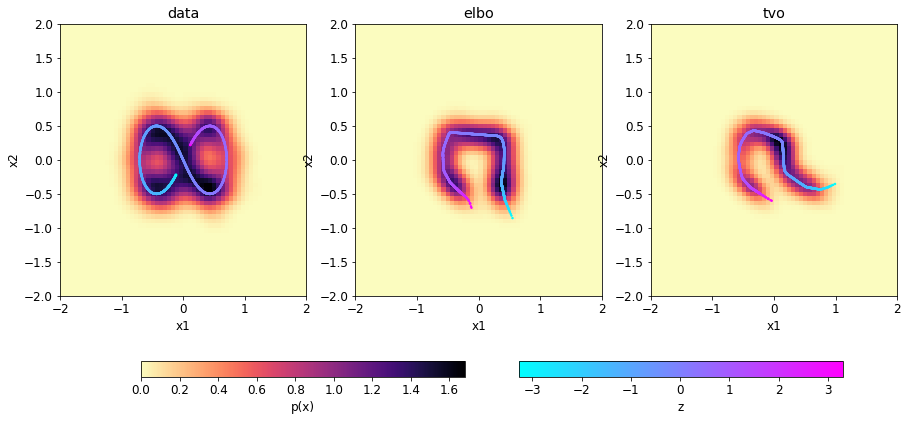

In [35]:
compare_VAE_line(elbo_lin_vae_instance, tvo_lin_vae_instance, 1, 2000, torch.normal(0, 1, size=(2000,1)),
                z_train, x_train, 0.02, 2, "magma_r", "cool","crosscurve")


True vs. learned f_theta(x)

/opt/venv/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([xs, ys, zs, np.ones_like(xs)])


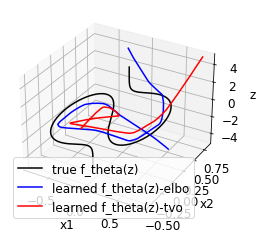

In [52]:
compare_VAE_true_function(elbo_vae_instance, tvo_vae_instance, z_dim=1, 
                 number_samples=10000, z_samples = torch.linspace(-5, 5, 10000), z_samples_np = np.linspace(-5, 5, 10000),
                               task="crosscurve")

/opt/venv/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([xs, ys, zs, np.ones_like(xs)])


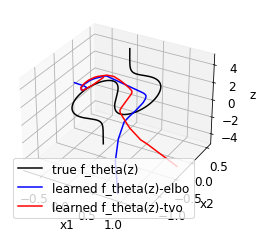

In [54]:
compare_VAE_true_function(elbo_lin_vae_instance, tvo_lin_vae_instance, z_dim=1, 
                 number_samples=10000, z_samples = torch.linspace(-5, 5, 10000), z_samples_np = np.linspace(-5, 5, 10000),
                               task="crosscurve")

Aggregated posterior vs. prior

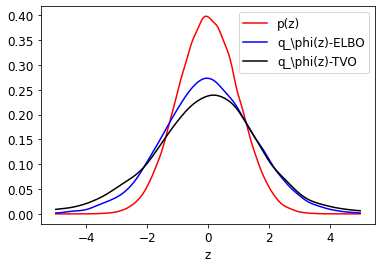

In [39]:
aggregated_posterior(elbo_vae_instance, tvo_vae_instance, x_train, 10)

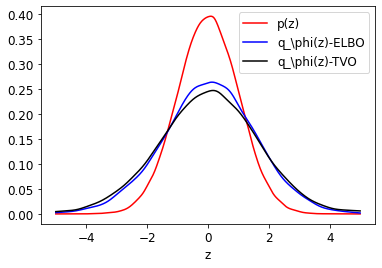

In [41]:
aggregated_posterior(elbo_lin_vae_instance, tvo_lin_vae_instance, x_train, 10)

True posterior vs. trained posterior

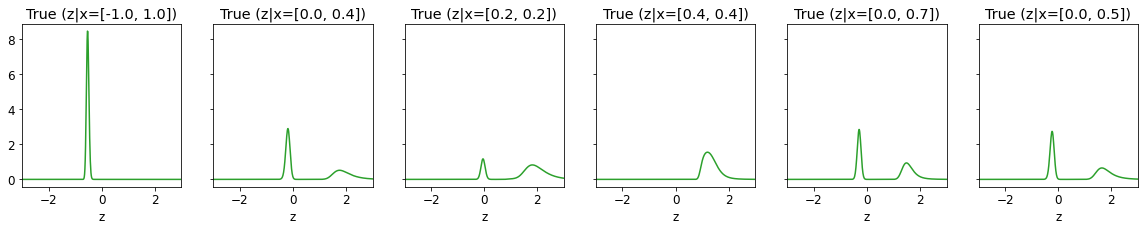

In [44]:
x_value_list = [[-1.0,1.0], [0.0, 0.4], [0.2, 0.2], [0.4, 0.4], [0.0, 0.7], [0.0, 0.5]]

def f_true_corssover(z):
    '''
    Output x_mean, given a z, based on True f
    '''
    u = lambda z: np.pi*(0.6+1.8*norm.cdf(z))
    f1 = lambda u: (1./np.sqrt(2))*(np.cos(u)/((np.sin(u))**2 + 1.))
    f2 = lambda u: (np.sqrt(2)) * (np.cos(u) * np.sin(u))/((np.sin(u))**2 + 1.)

    u_value= u(z)
    f1_value = f1(u_value) 
    f2_value = f2(u_value)
    return [f1_value, f2_value]

column_num = len(x_value_list)
fig, ax = plt.subplots(1,column_num, figsize=[20,3], sharey=True)
for i,x_value in enumerate(x_value_list):
    posterior_i = true_posterior(x_value, 0.02, f_true_corssover, np.linspace(-3,3,500))
    ax[i].plot(np.linspace(-3,3,500), posterior_i, lw=1.5, color='tab:green')
    ax[i].set_title('True p(z|x={})'.format(x_value))
    ax[i].set_xlabel('z')
    ax[i].set_xlim([-3,3])
#plt.suptitle('True Posterior', fontsize=18)
plt.show()

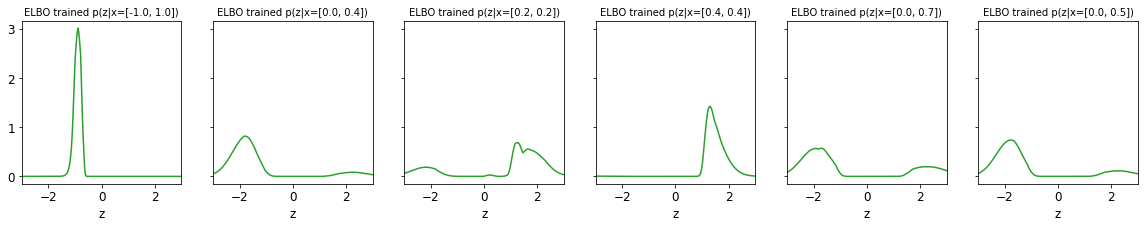

In [91]:
# ELBO without LIN Trick
column_num = len(x_value_list)
fig, ax = plt.subplots(1,column_num, figsize=[20,3], sharey=True)
for i,x_value in enumerate(x_value_list):
    posterior_i = trained_posterior(x_value, 0.02, elbo_vae_instance, z_list=np.linspace(-3,3,500))
    ax[i].plot(np.linspace(-3,3,500), posterior_i, lw=1.5, color='tab:green')
    ax[i].set_title('ELBO trained p(z|x={})'.format(x_value), fontsize=10)
    ax[i].set_xlabel('z')
    ax[i].set_xlim([-3,3])
#plt.suptitle('ELBO without LIN trick trained Posterior', fontsize=18)
plt.show()

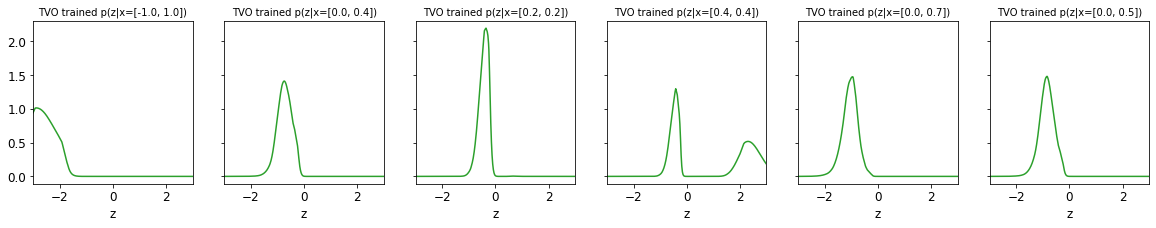

In [90]:
# TVO without LIN Trick
column_num = len(x_value_list)
fig, ax = plt.subplots(1,column_num, figsize=[20,3], sharey=True)
for i,x_value in enumerate(x_value_list):
    posterior_i = trained_posterior(x_value, 0.02, tvo_vae_instance, z_list=np.linspace(-3,3,500))
    ax[i].plot(np.linspace(-3,3,500), posterior_i, lw=1.5, color='tab:green')
    ax[i].set_title('TVO trained p(z|x={})'.format(x_value), fontsize=10)
    ax[i].set_xlabel('z')
    ax[i].set_xlim([-3,3])
#plt.suptitle('ELBO without LIN trick trained Posterior', fontsize=18)
plt.show()

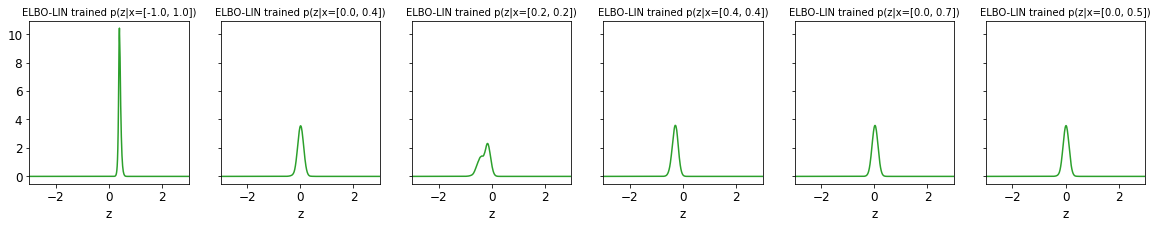

In [89]:
# ELBO with LIN Trick
column_num = len(x_value_list)
fig, ax = plt.subplots(1,column_num, figsize=[20,3], sharey=True)
for i,x_value in enumerate(x_value_list):
    posterior_i = trained_posterior(x_value, 0.02, elbo_lin_vae_instance, z_list=np.linspace(-3,3,500))
    ax[i].plot(np.linspace(-3,3,500), posterior_i, lw=1.5, color='tab:green')
    ax[i].set_title('ELBO-LIN trained p(z|x={})'.format(x_value), fontsize=10)
    ax[i].set_xlabel('z')
    ax[i].set_xlim([-3,3])
#plt.suptitle('ELBO with LIN trick trained Posterior', fontsize=18)
plt.show()

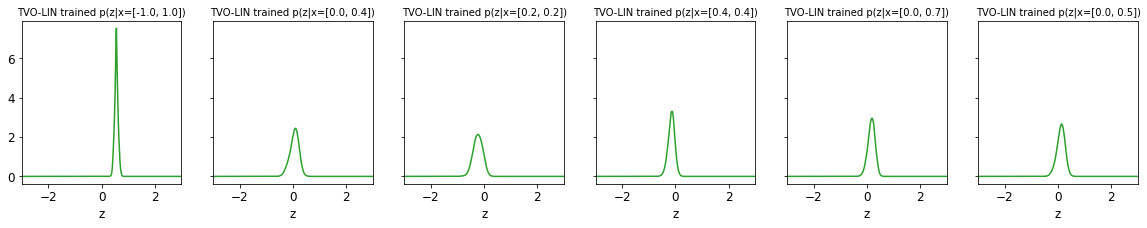

In [88]:
# TVO with LIN Trick
column_num = len(x_value_list)
fig, ax = plt.subplots(1,column_num, figsize=[20,3], sharey=True)
for i,x_value in enumerate(x_value_list):
    posterior_i = trained_posterior(x_value, 0.02, tvo_lin_vae_instance, z_list=np.linspace(-3,3,500))
    ax[i].plot(np.linspace(-3,3,500), posterior_i, lw=1.5, color='tab:green')
    ax[i].set_title('TVO-LIN trained p(z|x={})'.format(x_value), fontsize=10)
    ax[i].set_xlabel('z')
    ax[i].set_xlim([-3,3])
#plt.suptitle('TVO with LIN trick trained Posterior', fontsize=18)
plt.show()

#### Three clusters data

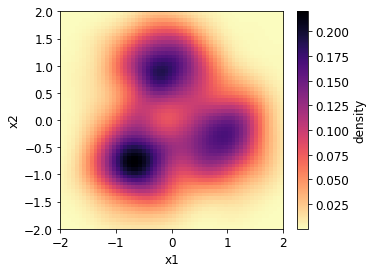

In [55]:
# Prepare data
z_train2 = np.random.normal(0,1,2000)
x_train2 = synthesize_threeclusters(sample_nums=2000)

z_val2 = np.random.normal(0,1,1000)
x_val2 = synthesize_crosscurve(sample_nums=1000, z_list=z_val2)

# Visualize training data pdf
visualize_pdf(x_train2, lim=2, c_map= 'magma_r')

Train VAE with ELBO objective

In [57]:
# Train with ELBO
# Most arguments of the following functions have reasonable default settings, i list them all here for a pedagogical reason
elbo_vae_instance2 = train_ELBO_VAE_batched(x_train2, 
                                                 x_var=0.2,
                                                 z_dim=1,
                                                 width=50,
                                                 hidden_layers=3,
                                                 learning_rate=0.001,
                                                 S=10,
                                                 n_epochs=5000,
                                                 report_iter=10,
                                                 batch_size=500,
                                                 device=device)
# Or use utils.random_start_ELBO_VAE() for several individual runs

100%|██████████| 100/100 [00:10<00:00,  9.47it/s]


Train VAE with TVO objective

In [58]:
# Train with TVO
tvo_vae_instance2 = train_TVO_VAE_batched(x_train2,
                                                x_var=0.2,
                                                z_dim=1,
                                                width=50,
                                                hidden_layers=3,
                                                learning_rate=0.001,
                                                partition=torch.tensor([0.0,0.25,0.50,0.75,1.0]),
                                                S=10,
                                                n_epochs=5000,
                                                report_iter=10,
                                                batch_size=500,
                                                device=device)
# Or use utils.random_start_TVO_VAE() for several individual runs

100%|██████████| 100/100 [00:05<00:00, 16.83it/s]


Train VAE with ELBO objective + LIN trick

In [59]:
# Train with ELBO + LIN
elbo_lin_vae_instance2 = train_ELBO_LIN_VAE_batched(x_train2,
                                                 x_val2,
                                                 x_var=0.2,
                                                 z_dim=1,
                                                 width=50,
                                                 hidden_layers=1,
                                                 learning_rate=0.01,
                                                 S=10,
                                                 n_epochs=5000,
                                                 report_iter=50,
                                                 batch_size=256,
                                                 device=device)

100%|██████████| 100/100 [00:21<00:00,  4.64it/s]


Train VAE with TVO objective + LIN trick

In [60]:
# Train with TVO + LIN
tvo_lin_vae_instance2 = train_TVO_LIN_VAE_batched(x_train2,
                                                x_val2,
                                                x_var=0.2,
                                                z_dim=1,
                                                width=50,
                                                hidden_layers=1,
                                                learning_rate=0.01,
                                                partition=torch.tensor([0.0,0.25,0.50,0.75,1.0]),
                                                S=10,
                                                n_epochs=5000,
                                                report_iter=50,
                                                batch_size=256,
                                                device=device)

100%|██████████| 100/100 [00:36<00:00,  2.77it/s]


Objective Trace

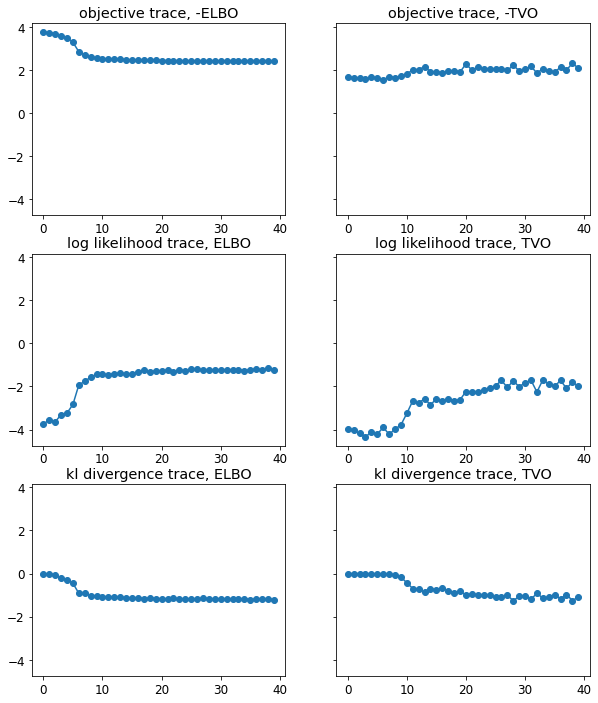

In [61]:
# Plot out the loss function, log likelihood, kl divergence trace
elbo_vae_instance_llkl2 = np.array(elbo_vae_instance2.llkhd_KL_trace).reshape(-1,2)
tvo_vae_instance_llkl2 = np.array(tvo_vae_instance2.llkhd_KL_trace).reshape(-1,2)
fig, ax=plt.subplots(3,2, figsize=(10,12), sharey=True)
ax[0][0].plot(elbo_vae_instance2.objective_trace, 'o-')
ax[0][0].set_title('objective trace, -ELBO')
ax[0][1].plot(tvo_vae_instance2.objective_trace, 'o-')
ax[0][1].set_title('objective trace, -TVO')
ax[1][0].plot(elbo_vae_instance_llkl2[:,0], 'o-')
ax[1][0].set_title('log likelihood trace, ELBO')
ax[1][1].plot(tvo_vae_instance_llkl2[:,0], 'o-')
ax[1][1].set_title('log likelihood trace, TVO')
ax[2][0].plot(-elbo_vae_instance_llkl2[:,1], 'o-')
ax[2][0].set_title('kl divergence trace, ELBO')
ax[2][1].plot(-tvo_vae_instance_llkl2[:,1], 'o-')
ax[2][1].set_title('kl divergence trace, TVO')
plt.show()

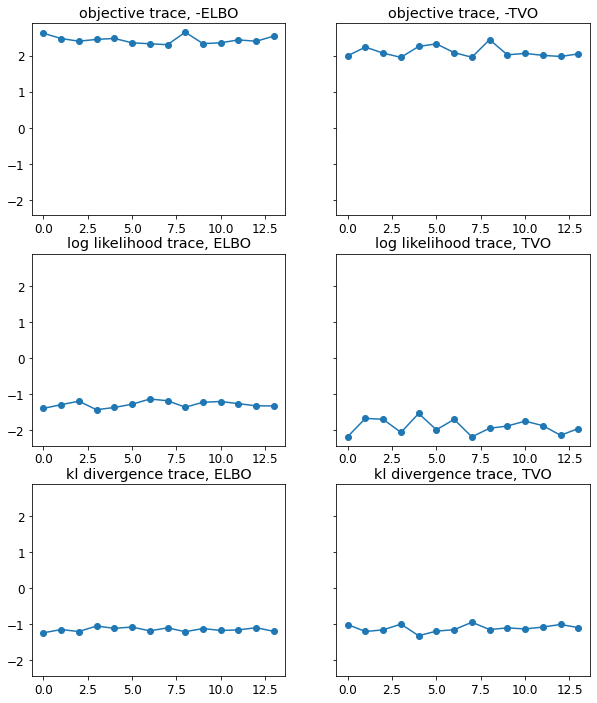

In [62]:
# Plot out the loss function, log likelihood, kl divergence trace
elbo_lin_vae_instance_llkl2 = np.array(elbo_lin_vae_instance2.llkhd_KL_trace).reshape(-1,2)
tvo_lin_vae_instance_llkl2 = np.array(tvo_lin_vae_instance2.llkhd_KL_trace).reshape(-1,2)
fig, ax=plt.subplots(3,2, figsize=(10,12), sharey=True)
ax[0][0].plot(elbo_lin_vae_instance2.objective_trace, 'o-')
ax[0][0].set_title('objective trace, -ELBO')
ax[0][1].plot(tvo_lin_vae_instance2.objective_trace, 'o-')
ax[0][1].set_title('objective trace, -TVO')
ax[1][0].plot(elbo_lin_vae_instance_llkl2[:,0], 'o-')
ax[1][0].set_title('log likelihood trace, ELBO')
ax[1][1].plot(tvo_lin_vae_instance_llkl2[:,0], 'o-')
ax[1][1].set_title('log likelihood trace, TVO')
ax[2][0].plot(-elbo_lin_vae_instance_llkl2[:,1], 'o-')
ax[2][0].set_title('kl divergence trace, ELBO')
ax[2][1].plot(-tvo_lin_vae_instance_llkl2[:,1], 'o-')
ax[2][1].set_title('kl divergence trace, TVO')
plt.show()

Compare PDF from decoder with the ground truth PDF

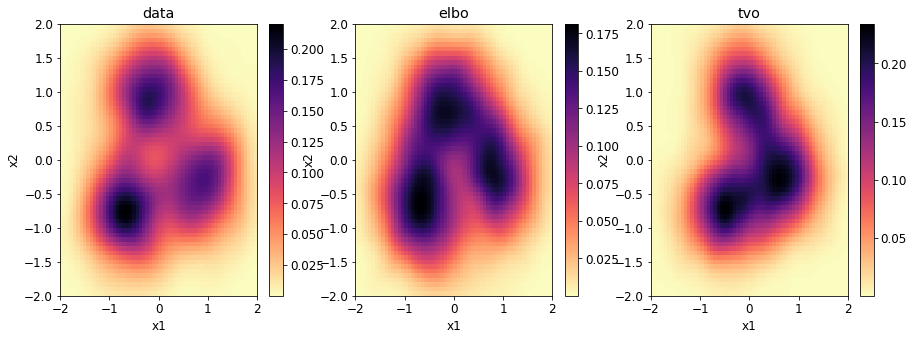

In [63]:
# Visualize PDF by a helper function
compare_VAE(elbo_vae_instance2, tvo_vae_instance2, x_train2,
                 number_samples=10000, x_var=0.2,
                 lim=2,
                 c_map='magma_r')

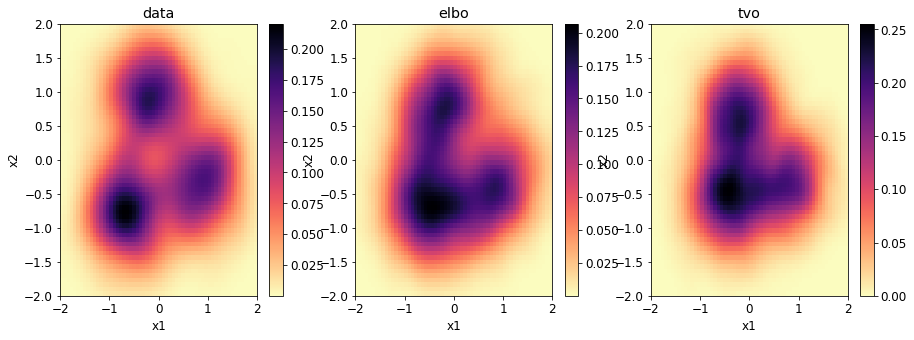

In [65]:
# Visualize PDF by a helper function
compare_VAE(elbo_lin_vae_instance2, tvo_lin_vae_instance2, x_train2,
                 number_samples=10000, x_var=0.2,
                 lim=2,
                 c_map='magma_r')

True vs. learned pθ(x), and learned vs. true fθ(z), colored by the value of z.

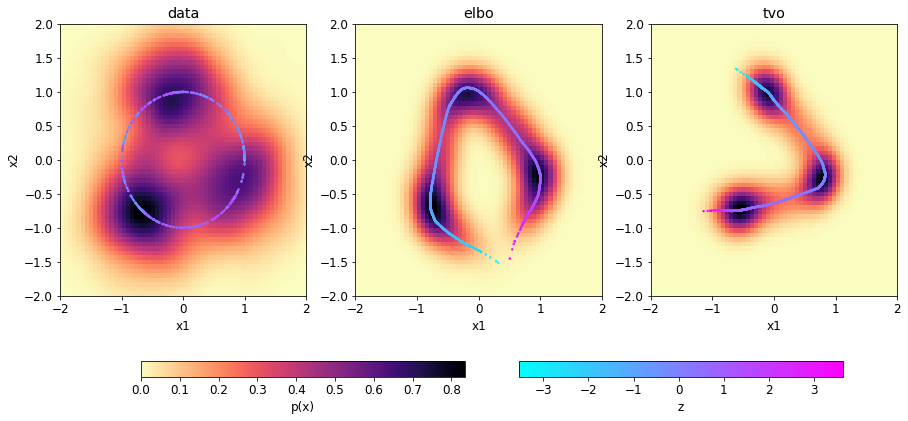

In [66]:
compare_VAE_line(elbo_vae_instance2, tvo_vae_instance2, 1, 2000, torch.normal(0, 1, size=(2000,1)),
                z_train2, x_train2, 0.2, 2, "magma_r", "cool","threeclusters")


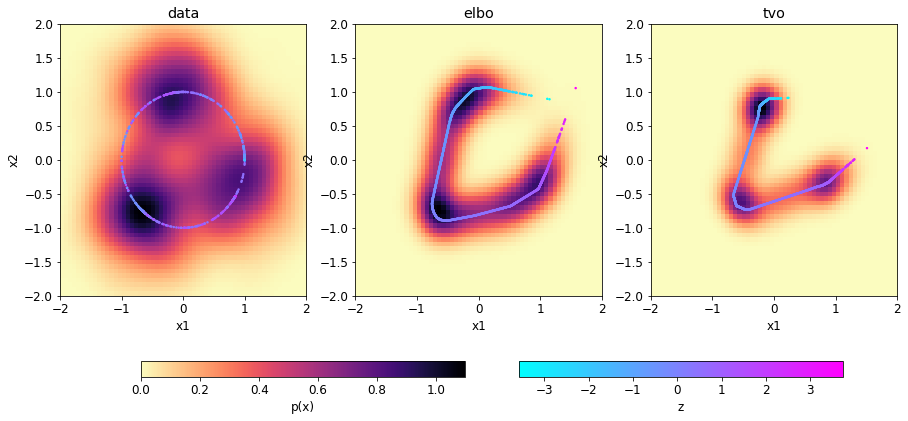

In [67]:
compare_VAE_line(elbo_lin_vae_instance2, tvo_lin_vae_instance2, 1, 2000, torch.normal(0, 1, size=(2000,1)),
                z_train2, x_train2, 0.2, 2, "magma_r", "cool","threeclusters")


True vs. learned f_theta(x)

/opt/venv/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([xs, ys, zs, np.ones_like(xs)])


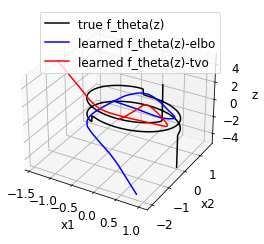

In [70]:
compare_VAE_true_function(elbo_vae_instance2, tvo_vae_instance2, z_dim=1, 
                 number_samples=10000, z_samples = torch.linspace(-5, 5, 10000), z_samples_np = np.linspace(-5, 5, 10000),
                               task='threeclusters')

/opt/venv/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([xs, ys, zs, np.ones_like(xs)])


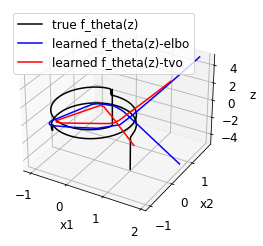

In [71]:
compare_VAE_true_function(elbo_lin_vae_instance2, tvo_lin_vae_instance2, z_dim=1, 
                 number_samples=10000, z_samples = torch.linspace(-5, 5, 10000), z_samples_np = np.linspace(-5, 5, 10000),
                               task='threeclusters')

Aggregated posterior vs. prior

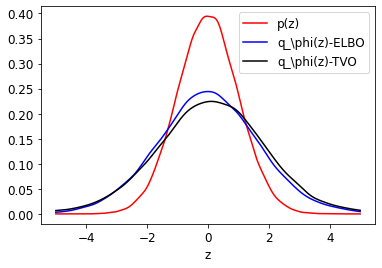

In [72]:
aggregated_posterior(elbo_vae_instance2, tvo_vae_instance2, x_train2, 10)

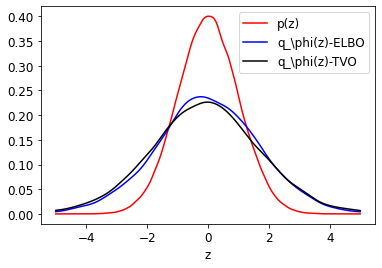

In [73]:
aggregated_posterior(elbo_lin_vae_instance2, tvo_lin_vae_instance2, x_train2, 10)

True Posterior vs. trained posterior

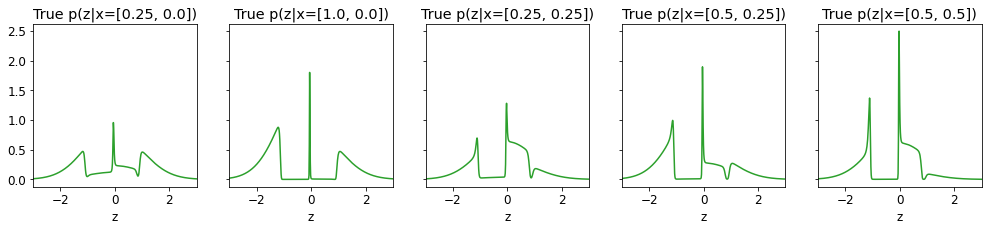

In [77]:
x_value_list2 = [[0.25,0.0], [1.0, 0.0], [0.25, 0.25], [0.50, 0.25], [0.50, 0.50]]

def f_true_threeclusters(z):
    '''
    Output x_mean, given a z, based on True f
    '''
    u = lambda z: (2*np.pi)/(1.+np.exp(-0.5*np.pi*z))
    t = lambda u: 2*np.tanh(10*u - 20*np.floor(u/2.) -10.) + 4.*np.floor(u/2.) + 2
    f1 = lambda t: np.cos(t)
    f2 = lambda t: np.sin(t)

    u_value = u(z)
    t_value = t(u_value)
    f1_value = f1(t_value)
    f2_value = f2(t_value)
    return [f1_value, f2_value]

column_num2 = len(x_value_list2)
fig, ax = plt.subplots(1,column_num2, figsize=[17,3], sharey=True)
for i,x_value in enumerate(x_value_list2):
    posterior_i = true_posterior(x_value, 0.2, f_true_threeclusters,np.linspace(-3,3,500))
    ax[i].plot(np.linspace(-3,3,500), posterior_i, lw=1.5, color='tab:green')
    ax[i].set_title('True p(z|x={})'.format(x_value))
    ax[i].set_xlabel('z')
    ax[i].set_xlim([-3,3])
#plt.suptitle('True Posterior', fontsize=18)
plt.show()

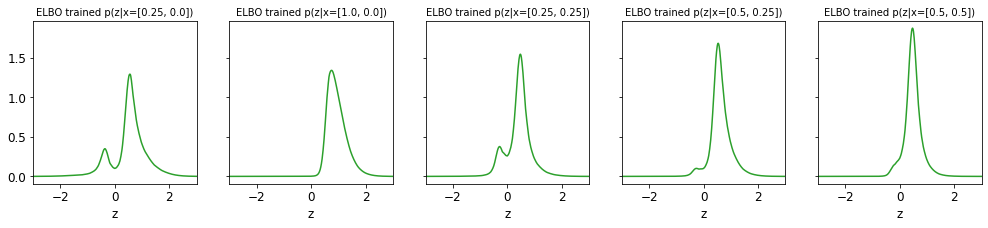

In [87]:
# ELBO without LIN Trick
column_num2 = len(x_value_list2)
fig, ax = plt.subplots(1,column_num2, figsize=[17,3], sharey=True)
for i,x_value in enumerate(x_value_list2):
    posterior_i = trained_posterior(x_value, 0.2, elbo_vae_instance2, z_list=np.linspace(-3,3,500))
    ax[i].plot(np.linspace(-3,3,500), posterior_i, lw=1.5, color='tab:green')
    ax[i].set_title('ELBO trained p(z|x={})'.format(x_value), fontsize=10)
    ax[i].set_xlabel('z')
    ax[i].set_xlim([-3,3])
#plt.suptitle('ELBO without LIN trick trained Posterior', fontsize=18)
plt.show()

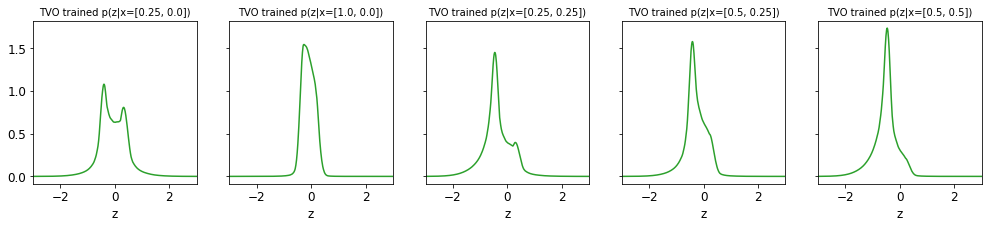

In [84]:
# TVO without LIN Trick
column_num2 = len(x_value_list2)
fig, ax = plt.subplots(1,column_num2, figsize=[17,3], sharey=True)
for i,x_value in enumerate(x_value_list2):
    posterior_i = trained_posterior(x_value, 0.2, tvo_vae_instance2, z_list=np.linspace(-3,3,500))
    ax[i].plot(np.linspace(-3,3,500), posterior_i, lw=1.5, color='tab:green')
    ax[i].set_title('TVO trained p(z|x={})'.format(x_value), fontsize=10)
    ax[i].set_xlabel('z')
    ax[i].set_xlim([-3,3])
#plt.suptitle('TVO without LIN trick trained Posterior', fontsize=18)
plt.show()

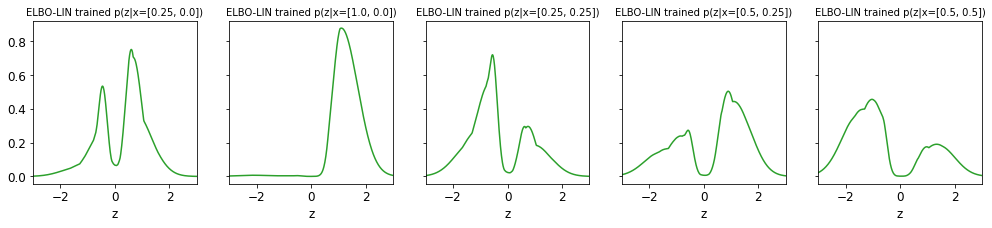

In [85]:
# ELBO with LIN Trick
column_num2 = len(x_value_list2)
fig, ax = plt.subplots(1,column_num2, figsize=[17,3], sharey=True)
for i,x_value in enumerate(x_value_list2):
    posterior_i = trained_posterior(x_value, 0.2, elbo_lin_vae_instance2, z_list=np.linspace(-3,3,500))
    ax[i].plot(np.linspace(-3,3,500), posterior_i, lw=1.5, color='tab:green')
    ax[i].set_title('ELBO-LIN trained p(z|x={})'.format(x_value), fontsize=10)
    ax[i].set_xlabel('z')
    ax[i].set_xlim([-3,3])
#plt.suptitle('ELBO with LIN trick trained Posterior', fontsize=18)
plt.show()

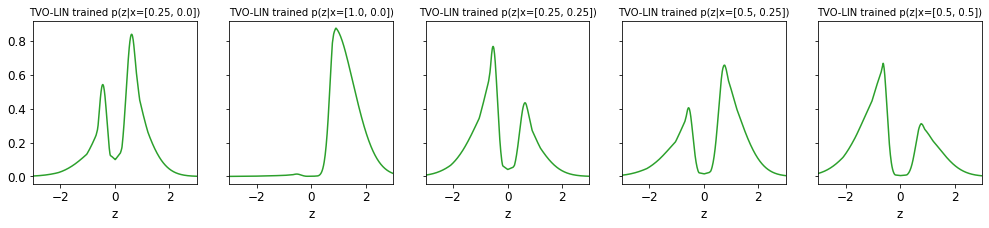

In [86]:
# TVO with LIN Trick
column_num2 = len(x_value_list2)
fig, ax = plt.subplots(1,column_num2, figsize=[17,3], sharey=True)
for i,x_value in enumerate(x_value_list2):
    posterior_i = trained_posterior(x_value, 0.2, tvo_lin_vae_instance2, z_list=np.linspace(-3,3,500))
    ax[i].plot(np.linspace(-3,3,500), posterior_i, lw=1.5, color='tab:green')
    ax[i].set_title('TVO-LIN trained p(z|x={})'.format(x_value), fontsize=10)
    ax[i].set_xlabel('z')
    ax[i].set_xlim([-3,3])
#plt.suptitle('ELBO with LIN trick trained Posterior', fontsize=18)
plt.show()